In [1]:
#helpful schema that Alan created to show connections between different dbs: 
#https://dbdiagram.io/d/5ceeb0811f6a891a6a658200

### Load in necessary libraries

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from numpy.random import seed
from numpy.random import randn
from scipy.stats import sem
from scipy.stats import t
from math import sqrt
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import pandas as pd

### Create functions to load database

In [3]:
def connect_to_sql_database(database_file_name):
    import sqlite3
    connection = sqlite3.connect(database_file_name)
    cursor = connection.cursor()
    return connection, cursor

In [4]:
conn, c = connect_to_sql_database('database1.sqlite')

In [5]:
def sql_query_to_df(cursor, sql_query):
    import pandas as pd
    c.execute(sql_query)
    df = pd.DataFrame(c.fetchall())
    df.columns = [x[0] for x in c.description]
    return df

In [6]:
def get_all_tables_from_sql_database(cursor):
    df = sql_query_to_df(c, """SELECT 
                                    name
                                FROM 
                                    sqlite_master 
                                WHERE 
                                    type ='table' AND 
                                    name NOT LIKE 'sqlite_%';""")
    return df

In [7]:
get_all_tables_from_sql_database(c)

,name
0,Player_Attributes
1,Player
2,Match
3,League
4,Country
5,Team
6,Team_Attributes


In [8]:
#Load up information from Match and Player_Attributes Databases
df = sql_query_to_df(c, """SELECT * FROM Match""")
print(df.head())
df1 = sql_query_to_df(c, """SELECT * FROM Player_Attributes""")
df1.head()

   id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492473              9987              9993               1  ...   
1        492474             10000              9994               0  ...   
2        492475              9984              8635               0  ...   
3        492476              9991              9998               5  ...   
4        492477              7947              9985               1  ...   

    SJA   VCH   VCD   VCA   GBH   GBD   GBA   BSH   BSD   BSA  
0  4.00  1.65  3.40  4.50  1.78  3.25  4.00  1.73  3

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [9]:
#Check columns in each Database to be analyzed 
print(df.columns)
df1.columns

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object', length=115)


Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [10]:
df1[['aggression', 'interceptions']].head()

,aggression,interceptions
0,71.0,70.0
1,71.0,70.0
2,63.0,41.0
3,62.0,40.0
4,62.0,40.0


### Get summary statistics of columns of interest

In [11]:
# Goals look good, no need to handle NaN's
print(df[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].isna().sum())
# Has some NaNs to be handled
print(df1.shape)
df1[['aggression', 'interceptions']].isna().sum()

home_team_api_id    0
away_team_api_id    0
home_team_goal      0
away_team_goal      0
dtype: int64
(183978, 42)


aggression       836
interceptions    836
dtype: int64

In [12]:
#filling in missing values with mean

df1.aggression.fillna((df1.aggression.mean()), inplace=True)
df1.interceptions.fillna((df1.interceptions.mean()), inplace=True)

In [13]:
# df1.aggression.fillna((df1.aggression.mean()), inplace=True)
df1.aggression[373]

71.0

In [14]:
#Examining summary statistics of the four columns I plan to use
print(df[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].describe())
df1[['aggression', 'interceptions']].describe()

       home_team_api_id  away_team_api_id  home_team_goal  away_team_goal
count      25979.000000      25979.000000    25979.000000    25979.000000
mean        9984.371993       9984.475115        1.544594        1.160938
std        14087.453758      14087.445135        1.297158        1.142110
min         1601.000000       1601.000000        0.000000        0.000000
25%         8475.000000       8475.000000        1.000000        0.000000
50%         8697.000000       8697.000000        1.000000        1.000000
75%         9925.000000       9925.000000        2.000000        2.000000
max       274581.000000     274581.000000       10.000000        9.000000


,aggression,interceptions
count,183978.000000,183978.000000
mean,60.948046,52.009271
std,16.052924,19.405891
min,6.000000,1.000000
25%,51.000000,34.000000
50%,64.000000,56.000000
75%,73.000000,68.000000
max,97.000000,96.000000


In [15]:
#All are integers
print(df[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].info())
#Both are Floats
df1[['aggression', 'interceptions']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 4 columns):
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
dtypes: int64(4)
memory usage: 811.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 2 columns):
aggression       183978 non-null float64
interceptions    183978 non-null float64
dtypes: float64(2)
memory usage: 2.8 MB


### Explore columns of interest visually

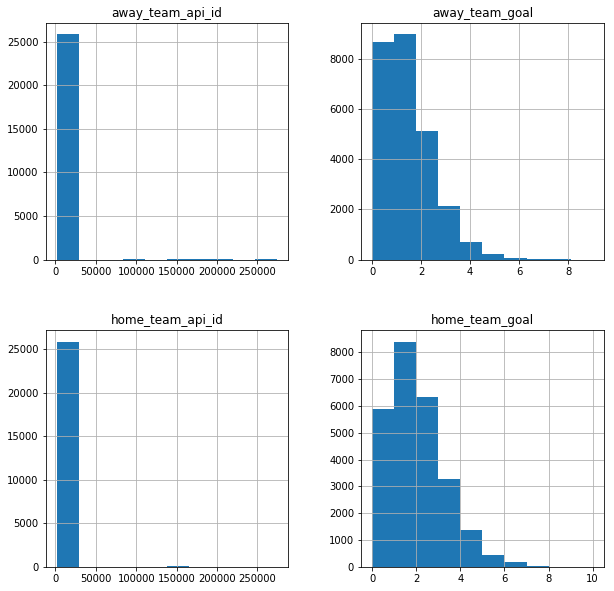

In [16]:
graph = df[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].hist(figsize=(10,10))

In [17]:
# #will need to use log transformation for goal metrics to be able to conduct T-tests
# graph = np.log(np.isfinite(df[['HomeWin', 'AwayWin']])).hist(figsize=(5,5), bins = 10)
# #This is Boolean! As in the Home or Away win is either True or False. So, I will do a chisquared test instead.
# #These two new columns are defined below

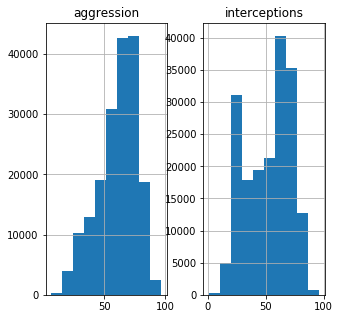

In [18]:
#This is a better candidate for a log transformation
graph = df1[['aggression', 'interceptions']].hist(figsize =(5,5))

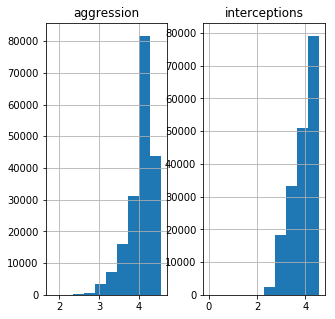

In [19]:
#is this an improvement toward a more normal distribution?
graph = np.log(df1[['aggression', 'interceptions']]).hist(figsize =(5,5))

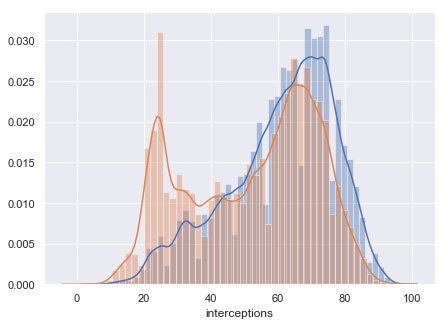

In [244]:
#This overlay shows the correlation is basically what I hypothesize, but with an interesting uptick 
# in low numbers of interceptions
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(7,5)})
sns.distplot(df1.aggression) # Blue distribution
sns.distplot(df1.interceptions) # Orangey distribution

i1 = df1.interceptions[:91989]
i2 = df1.interceptions[91989:]
#Mann-Whitney test here? It tests that the two distributions are the same, and my 
# alternative hypothesis would be that they are not
#Also look into KS test, or a permutation test

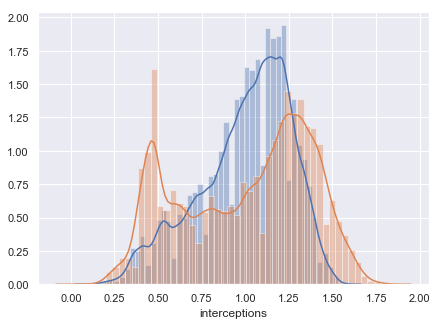

In [196]:
Am = A/A.mean()
Im = I/I.mean()
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(7,5)})
sns.distplot(Am) # Blue distribution
sns.distplot(Im) # Orangey distribution

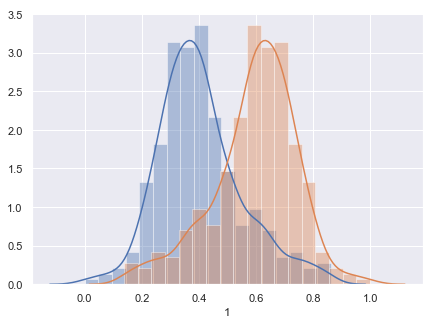

In [143]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(7,5)})
sns.distplot(binary[0]) # Blue distribution
sns.distplot(binary[1]) # Orangey distribution

### Create columns for Home/Away/Draw
#### Need to answer this question: Is there a statistical difference in the odds of winning a game when a team is playing in front of their home crowd?

In [122]:
# #(From Joe): Sets up columns to see who won or lost or draw
# df['HomeWin']=df.home_team_goal>df.away_team_goal
# df['AwayWin']=df.away_team_goal>df.home_team_goal
# df['Draw']=df.home_team_goal==df.away_team_goal
# print(len(df['HomeWin']))
# print(len(df['AwayWin']))
# foo = df.groupby(df.home_team_api_id)
# foo2 = foo.groups
# foo3

# df.head()
# foo = df.groupby(df.home_team_api_id)
# x=foo.get_group(1601)
# #Sets up columns to see who won or lost or draw

# win_per = x.HomeWin.sum()/len(x.HomeWin)
# windict = {}

def getwinpercents(df):
    win_dict={}
    #for home wins
    foo_home = df.groupby(df.home_team_api_id) #slice by home id
    foo_away = df.groupby(df.away_team_api_id) #slice by away id
    team_ids = list(foo.groups.keys()) #get individual team ids
    #calculate and store home win percentages
    for team in team_ids:
        x=foo_home.get_group(team) #grab home wins
        y=foo_away.get_group(team) #grab away wins
        
        home_per=x.HomeWin.sum()/len(x.HomeWin) #calculate
        away_per=y.AwayWin.sum()/len(y.AwayWin)
        draw_per=(1 - (home_per+away_per)) #seems to give draws as remaining percentages of games 
                                            #not marked as Home/Away wins,  but team5 has -.03% draws, might be
                                            # rounding error
        win_dict[team]=[home_per,away_per,draw_per] #store

        
        
    win_df=pd.DataFrame(win_dict).T
    return win_df

per_df = getwinpercents(df)

per_df.head()

,0,1,2
1601,0.450000,0.316667,0.233333
1773,0.355556,0.133333,0.511111
1957,0.525000,0.200000,0.275000
2033,0.253333,0.173333,0.573333
2182,0.616667,0.416667,-0.033333


In [124]:
def homewinbinary(df):
    win_dict={}
    #for home wins
    foo_home = df.groupby(df.home_team_api_id) #slice by home id
    foo_away = df.groupby(df.away_team_api_id) #slice by away id
    team_ids = list(foo.groups.keys()) #get individual team ids
    #calculate and store home win percentages
    for team in team_ids:
        x=foo_home.get_group(team) #grab home wins
        y=foo_away.get_group(team) #grab everything else
        
        home_per=x.HomeWin.sum()/len(x.HomeWin) #calculate Home Wins
        else_per=(1 - home_per) #calculate complement of Home Wins
        
        win_dict[team]=[home_per,else_per] #store

        
        
    win_df=pd.DataFrame(win_dict).T
    return win_df
binary = homewinbinary(df)
binary.head()

,0,1
1601,0.450000,0.550000
1773,0.355556,0.644444
1957,0.525000,0.475000
2033,0.253333,0.746667
2182,0.616667,0.383333


In [22]:
#(From Joe)
df.HomeWin.sum()/df.HomeWin.shape[0]

0.45871665576042187

In [23]:
#The effect size of playing home/away appears to be substantial
df.AwayWin.sum()/df.AwayWin.shape[0]

0.28738596558759

In [24]:
df.Draw.sum()/df.Draw.shape[0]

0.25389737865198814

### Trying out different kinds of statistical tests
Look at two metrics associated with the offensive side of the game, interceptions and aggression, and test to see if they are positively correlated within a confidence interval of .05

Do a Chisquared test and some others on HomeWin and AwayWin columns further below

### First start out with a heatmap

In [80]:
wins = df[['HomeWin', 'AwayWin', 'Draw']]
offense = df1[['aggression', 'interceptions']]

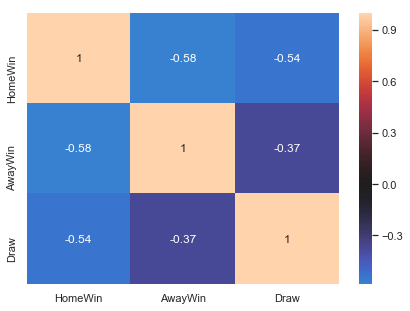

In [173]:
sns.heatmap(wins.corr(), annot=True, center=0);

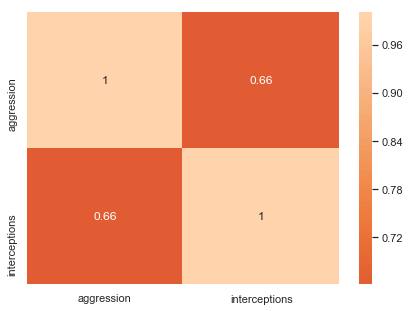

In [172]:
sns.heatmap(offense.corr(), annot=True, center=0);

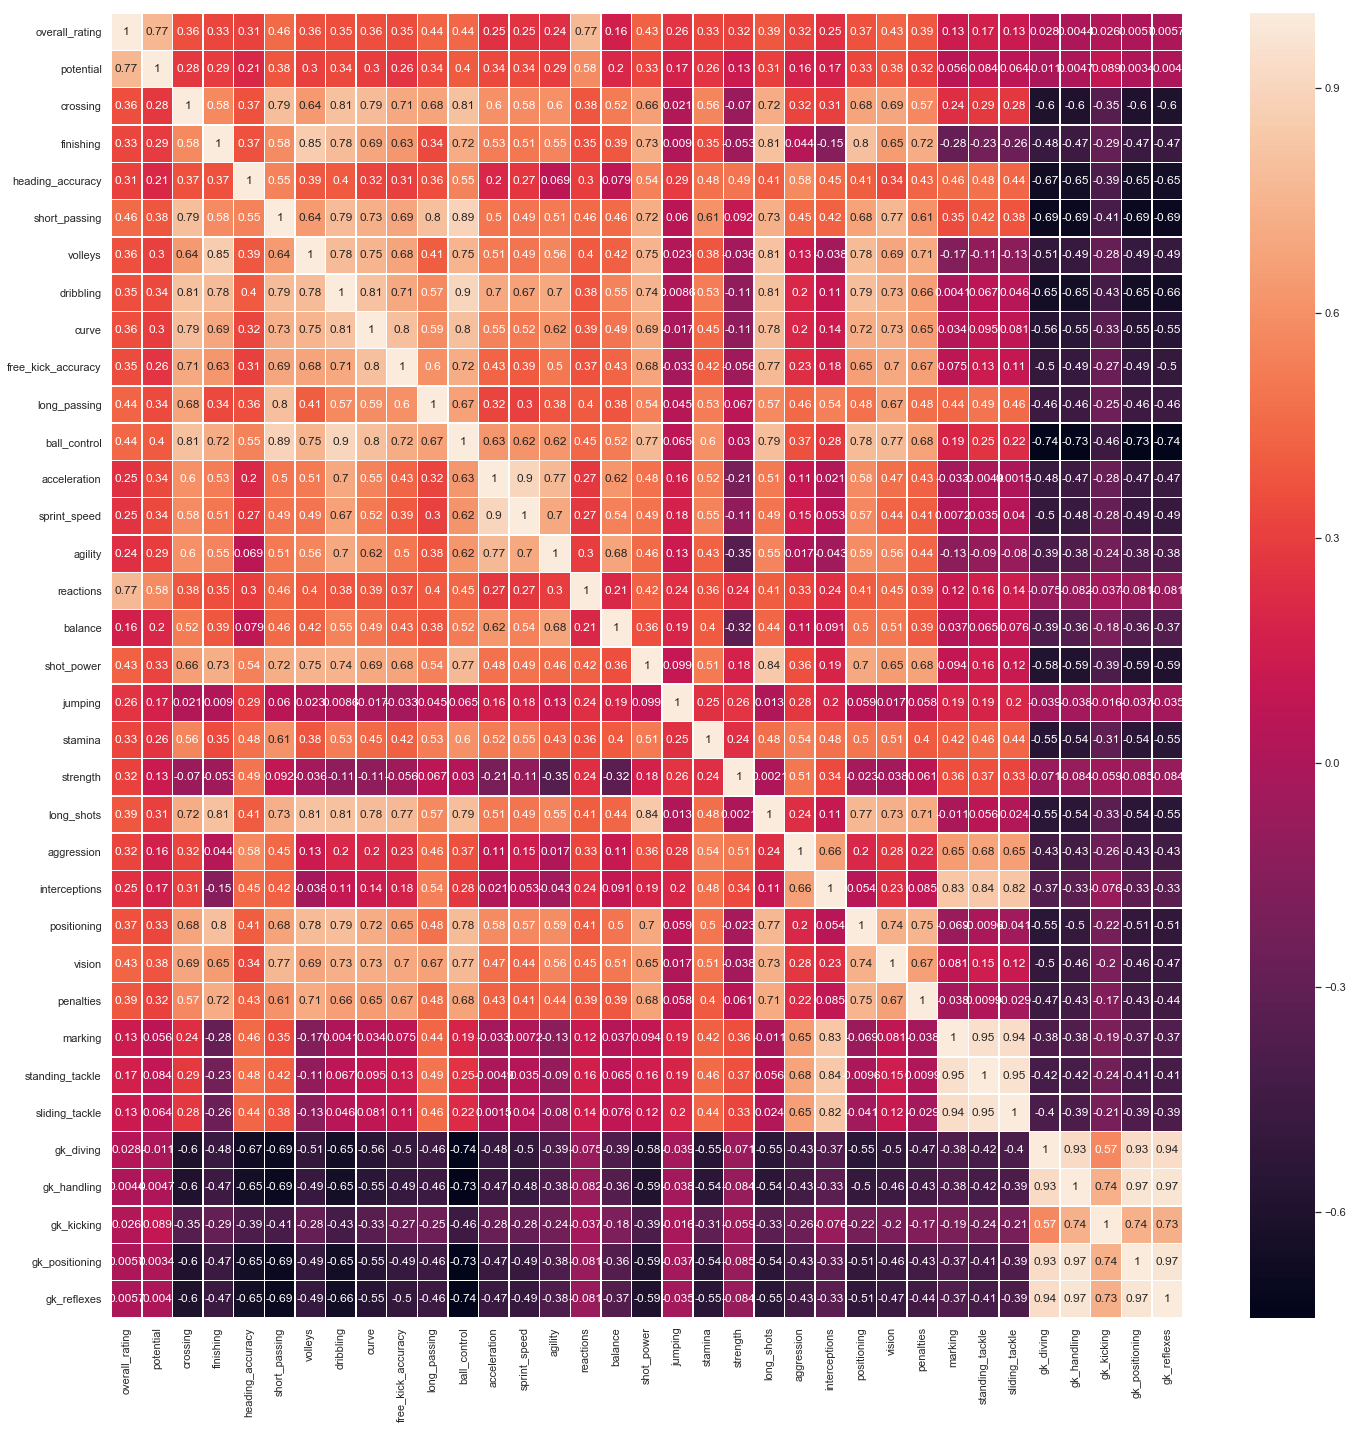

In [171]:
#all player attributes
corr2 = df1.select_dtypes(include =['float64','int64']).\
loc[:,df1.select_dtypes(include =['float64','int64']).columns[3:]].corr()
fig2,ax2 = plt.subplots(nrows = 1,ncols = 1)
fig2.set_size_inches(w=24,h=24)
sns.heatmap(corr2,annot = True,linewidths=0.5,ax = ax2)

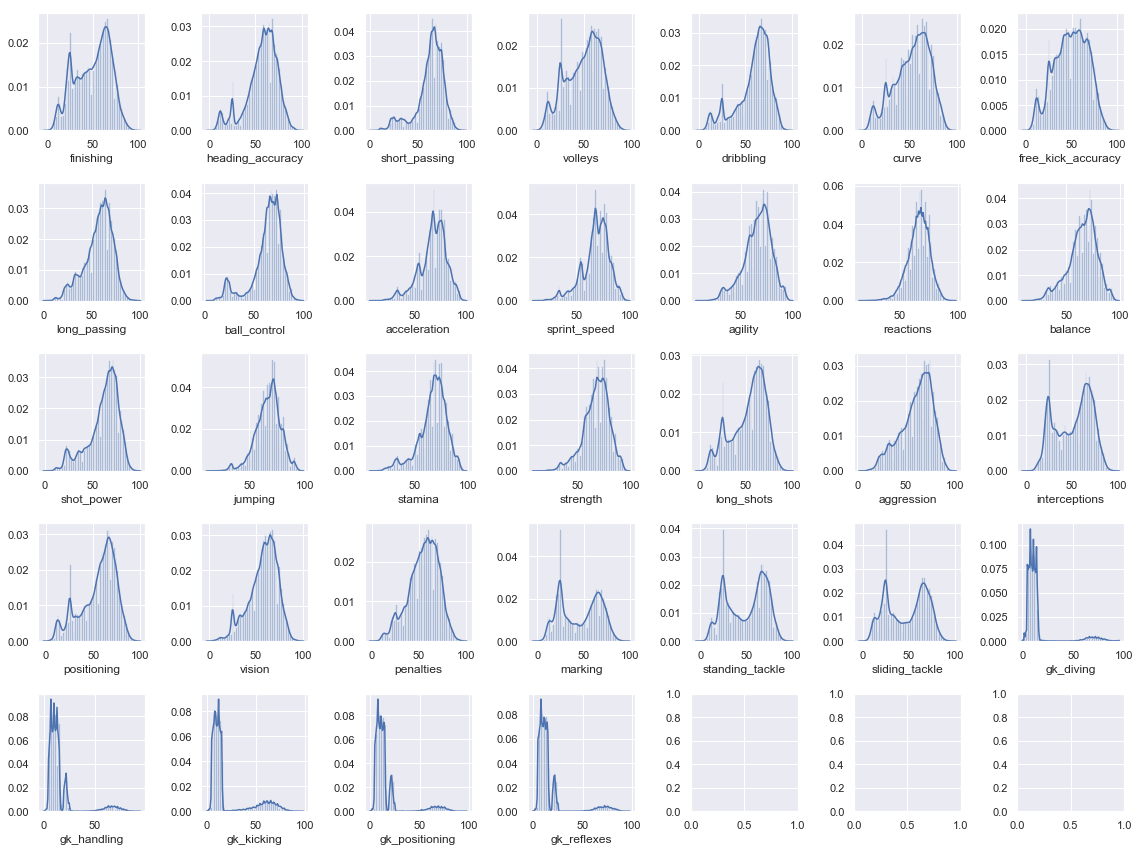

In [215]:
fig6, ax6 = plt.subplots(nrows=5,ncols=7)
fig6.set_size_inches(16,12)

foo=df1.dropna()
a=foo.select_dtypes(include=['float64']).columns[3:].tolist()
a

i=0
for j in a:
     b = foo[j]
     sns.distplot(b, ax = ax6[int(i/7)][i%7])
     i=i+1
#     len(b)
fig6.tight_layout()

In [206]:
df1.dtypes

id                       int64
player_fifa_api_id       int64
player_api_id            int64
date                    object
overall_rating         float64
potential              float64
preferred_foot          object
attacking_work_rate     object
defensive_work_rate     object
crossing               float64
finishing              float64
heading_accuracy       float64
short_passing          float64
volleys                float64
dribbling              float64
curve                  float64
free_kick_accuracy     float64
long_passing           float64
ball_control           float64
acceleration           float64
sprint_speed           float64
agility                float64
reactions              float64
balance                float64
shot_power             float64
jumping                float64
stamina                float64
strength               float64
long_shots             float64
aggression             float64
interceptions          float64
positioning            float64
vision  

In [ ]:
fig6, ax6 = plt.subplots(nrows=5,ncols=7)
fig6.set_size_inches(16,12)
for i,j in enumerate(df1.select_dtypes(include = ['float64','int64']).columns[3:].tolist()):
    sns.boxplot(x = "interceptions", y = j, data=df1, ax = ax6[int(i/7)][i%7])
fig6.tight_layout()

#### Independent Ttests - don't yield any meaningful insight, with or without log transformation

In [25]:
#https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/
#https://www.sagepub.com/sites/default/files/upm-binaries/33663_Chapter4.pdf
#consulted these resources for help with statistical helping

#https://www.kaggle.com/efezinoerome/analyzing-soccer-data
#http://www.statstutor.ac.uk/resources/uploaded/tutorsquickguidetostatistics.pdf
#also consulted

In [26]:
#w/out Log Normalization
x = df1.aggression
y = df1.interceptions
ttest=stats.ttest_ind(x,y)
print('t-test independent', ttest)

t-test independent Ttest_indResult(statistic=152.23647013716408, pvalue=0.0)


In [27]:
#w/ Log Normalization
x = np.log(df1.aggression)
y = np.log(df1.interceptions)
ttest=stats.ttest_ind(x,y)
print('t-test independent', ttest)

t-test independent Ttest_indResult(statistic=157.39150284089047, pvalue=0.0)


In [28]:
# '''
# This is why neither is meaningful here: the population distribution of the aggression and interceptions
# variables are not identical, they do not have identical variances. 

# Calculates the T-test for the means of *two independent* samples of scores.

# This is a two-sided test for the null hypothesis that 2 independent samples
# have identical average (expected) values. This test assumes that the
# populations have identical variances by default.
# '''

#### two and one tailed t-tests on aggression and interceptions

In [29]:
A = df1.aggression
I = df1.interceptions

In [60]:
H = df.HomeWin
Aw = df.AwayWin

In [30]:
#Let's compare means here:
meanA = df1.aggression.mean()
meanI = df1.interceptions.mean()
meanA-meanI

8.938774284435986

In [31]:
print(meanI)

52.00927149425033


In [32]:
print(meanA)

60.948045778686314


In [33]:
# getting standard errors
se1, se2 = sem(df1.aggression), sem(df1.interceptions)

In [34]:
df1.interceptions.std()

19.40589133362253

In [35]:
df1.aggression.std()

16.052923625057335

In [36]:
# standard error on difference between samples
sed = sqrt(se1**2.0 + se2**2.0)

In [37]:
# getting t-statistic
t_stat = (meanA - meanI) / sed
t_stat

152.23647013718028

In [38]:
#degrees of freedom
degf = len(df1.aggression) + len(df1.interceptions) - 2

In [39]:
#critical value, .05
cv = t.ppf(1.0 - .05, degf)
cv

1.6448577681566425

In [40]:
# p-value
p = (1.0 - t.cdf(abs(t_stat), degf)) * 2.0
p

0.0

In [41]:
def independent_ttest(data1, data2, alpha):
	# calculate means
	mean1, mean2 = data1.mean(), data2.mean()
	# calculate standard errors
	se1, se2 = sem(data1), sem(data2)
	# standard error on the difference between the samples
	sed = sqrt(se1**2.0 + se2**2.0)
	# calculate the t statistic
	t_stat = (mean1 - mean2) / sed
	# degrees of freedom
	degf = len(data1) + len(data2) - 2
	# calculate the critical value
	cv = t.ppf(1.0 - alpha, degf)
	# calculate the p-value
	p = (1.0 - t.cdf(abs(t_stat), degf)) * 2.0
	# return everything
	return t_stat, degf, cv, p
 
# seed the random number generator
seed(1)
# generate two independent samples
data1 = 5 * randn(100) + 50
data2 = 5 * randn(100) + 51
# calculate the t test
alpha = 0.05
t_stat, degf, cv, p = independent_ttest(data1, data2, alpha)
print('t=%.3f, df=%d, cv=%.3f, p=%.3f' % (t_stat, degf, cv, p))
# interpret via critical value
if abs(t_stat) <= cv:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are equal.')
# interpret via p-value
if p > alpha:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are equal.')

t=-2.262, df=198, cv=1.653, p=0.025
Reject the null hypothesis that the means are equal.
Reject the null hypothesis that the means are equal.


In [42]:
def dependent_ttest(data1, data2, alpha):
	# calculate means
	mean1, mean2 = data1.mean(), data2.mean()
	# number of paired samples
	n = len(data1)
	# sum squared difference between observations
	d1 = sum([(data1[i]-data2[i])**2 for i in range(n)])
	# sum difference between observations
	d2 = sum([data1[i]-data2[i] for i in range(n)])
	# standard deviation of the difference between means
	sd = sqrt((d1 - (d2**2 / n)) / (n - 1))
	# standard error of the difference between the means
	sed = sd / sqrt(n)
	# calculate the t statistic
	t_stat = (mean1 - mean2) / sed
	# degrees of freedom
	degf = n - 1
	# calculate the critical value
	cv = t.ppf(1.0 - alpha, degf)
	# calculate the p-value
	p = (1.0 - t.cdf(abs(t_stat), degf)) * 2.0
	# return everything
	return t_stat, degf, cv, p


# seed the random number generator
seed(1)
# generate two independent samples (pretend they are dependent)
data1 = 5 * randn(100) + 50
data2 = 5 * randn(100) + 51
# calculate the t test
alpha = 0.05
t_stat, degf, cv, p = dependent_ttest(data1, data2, alpha)
print('t=%.3f, df=%d, cv=%.3f, p=%.3f' % (t_stat, degf, cv, p))
# interpret via critical value
if abs(t_stat) <= cv:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are equal.')
# interpret via p-value
if p > alpha:
	print('Accept null hypothesis that the means are equal.')
else:
	print('Reject the null hypothesis that the means are equal.')

t=-2.372, df=99, cv=1.660, p=0.020
Reject the null hypothesis that the means are equal.
Reject the null hypothesis that the means are equal.


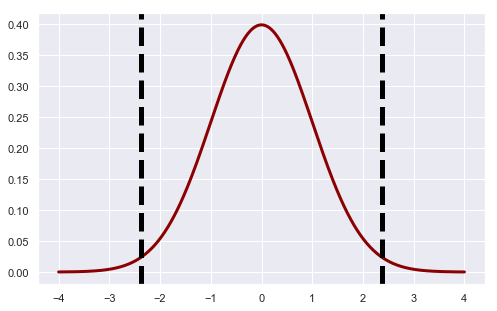

In [61]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4,4,500)
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    ys = stats.t.pdf(xs, (n_control+n_experimental)-2, 0, 1)
    # Draw two sided boundary for critical-t
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_cont = len(A)
n_exp = len(I)
visualize_t(t_stat, n_cont, n_exp)

In [44]:
independent_ttest(A, I, .05)

(152.23647013718028, 367954, 1.6448577681566425, 0.0)

In [227]:
independent_ttest(A, i1, .05)

(3.0745584030598305, 184026, 1.6448619071774457, 0.0021084529909580763)

In [228]:
independent_ttest(A, i2, .05)

(152.23516142594073, 367904, 1.6448577687194545, 0.0)

In [45]:
dependent_ttest(A, I, .05)

(257.24873785274247, 183977, 1.644861909382793, 0.0)

In [232]:
independent_ttest(x, y, .05)

(-15.922891830687318, 596, 1.6474142893807813, 0.0)

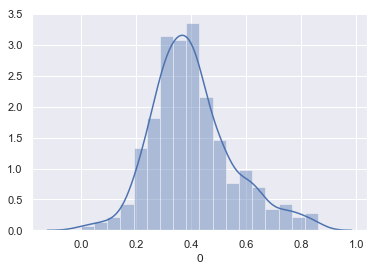

In [133]:
sns.distplot(binary[0])

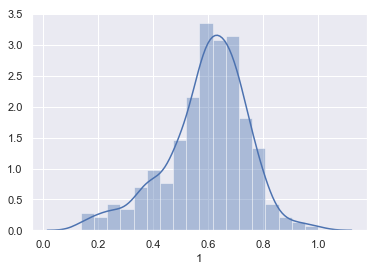

In [134]:
sns.distplot(binary[1])

In [127]:
binary.head()

,0,1
1601,0.450000,0.550000
1773,0.355556,0.644444
1957,0.525000,0.475000
2033,0.253333,0.746667
2182,0.616667,0.383333


In [132]:
independent_ttest(binary.iloc[:,0], binary.iloc[:,1], .05)

(-15.922891830687318, 596, 1.6474142893807813, 0.0)

In [136]:
dependent_ttest(binary[0], binary[1], .05)

KeyError: 0

In [145]:
x = binary[0]
y = binary[1]
ttest=stats.ttest_ind(x,y)
print('T-test independent, one tailed p-value: ', ttest[1])

T-test independent, one tailed p-value:  7.977152115768083e-48


In [144]:
#This is a single t-test for one comparison between playing at home or not playing at home
x = binary[0]
y = binary[1]
ttest=stats.ttest_ind(x,y)
print('T-test independent, two tailed p-value: ', ttest[1]*2)

T-test independent, two tailed p-value:  1.5954304231536166e-47


In [146]:
x = binary[0]
y = binary[1]
ttest=stats.ttest_ind(A,I)
print('T-test independent, two tailed p-value: ', ttest[1]*2)

T-test independent, two tailed p-value:  0.0


In [148]:
x = binary[0]
y = binary[1]
ttest=stats.ttest_ind(A,I)
print('T-test independent, one tailed p-value: ', ttest[1])

T-test independent, one tailed p-value:  0.0


In [235]:
ttest=stats.ttest_ind(A,i1)
print('T-test independent, one tailed p-value: ', ttest[1])
print('T-test independent, two tailed p-value: ', ttest[1]*2)

T-test independent, one tailed p-value:  0.030637107771262877
T-test independent, two tailed p-value:  0.06127421554252575


In [234]:
ttest=stats.ttest_ind(A,i2)
print('T-test independent, one tailed p-value: ', ttest[1])

T-test independent, one tailed p-value:  0.0


### KS testing aggressive and interceptions

In [188]:
stats.kstest(np.log(A), 'norm')

KstestResult(statistic=0.9951702240861843, pvalue=0.0)

In [150]:
stats.kstest(I, 'norm')

KstestResult(statistic=0.9999507944559518, pvalue=0.0)

In [151]:
stats.kstest(stats.t.rvs(100,A),'norm')

KstestResult(statistic=0.9999999999858968, pvalue=0.0)

In [152]:
stats.kstest(stats.t.rvs(100,I),'norm')

KstestResult(statistic=0.9999548661623797, pvalue=0.0)

In [158]:
stats.kstest(stats.t.rvs(1,A),'norm')

KstestResult(statistic=0.9933622348952449, pvalue=0.0)

In [160]:
rvs1 = stats.norm.rvs(A, loc=0., scale=1)
rvs2 = stats.norm.rvs(I, loc=0.5, scale=1.5)
stats.ks_2samp(rvs1, rvs2)

TypeError: _parse_args_rvs() got multiple values for argument 'loc'

In [217]:
stats.mannwhitneyu(A,I)

MannwhitneyuResult(statistic=12538323982.0, pvalue=0.0)

In [221]:
stats.mannwhitneyu(A,I,alternative='less')

MannwhitneyuResult(statistic=21309580502.0, pvalue=1.0)

In [224]:
stats.mannwhitneyu(x,y,alternative='greater')

MannwhitneyuResult(statistic=15739.5, pvalue=1.0)

In [225]:
stats.mannwhitneyu(x,y)

MannwhitneyuResult(statistic=15739.5, pvalue=4.452380650142112e-43)

In [236]:
stats.mannwhitneyu(A,i1)

MannwhitneyuResult(statistic=3445719.0, pvalue=0.001061818002698792)

In [237]:
stats.mannwhitneyu(A,i2)

MannwhitneyuResult(statistic=12534878263.0, pvalue=0.0)

### permutation testing

In [163]:
A.shape

(183978,)

In [164]:
I.shape

(183978,)

In [161]:
theta_hat = A.mean() - I.mean()
theta_hat

8.938774284435986

In [ ]:
#create a function to run your permutation

def run_permutation_test(pooled,sizeZ,sizeY,delta):
    #randomize all the pooled data from arrays y and z
    np.random.shuffle(pooled)
    #grab data the length of z
    starZ = pooled[:sizeZ]
    #grab the rest of the data the length of y
    starY = pooled[-sizeY:]
    #find the difference in the mean
    return starZ.mean() - starY.mean()

In [ ]:
#using the full length of dataset breaks this, but using a reduced number of samples always just returns 0

In [169]:
pooled = np.hstack([A,I])
delta = A.mean() - I.mean()
numSamples = 1000
estimates = np.array(list(map(lambda x: run_permutation_test(pooled,A.size,I.size,delta),range(numSamples))))
diffCount = len(np.where(estimates < delta)[0])
hat_sig_perm = 1.0 - (float(diffCount)/float(numSamples))
hat_sig_perm

0.0

In [189]:
from mlxtend.evaluate import permutation_test

p_value = permutation_test(A, I,
                           method='approximate',
                           num_rounds=10000,
                           seed=0)
print(p_value)

0.0


### Welch's T-test

In [46]:
def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """

    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

welch_t(A, I)


152.2364701371744

In [62]:
welch_t(H, Aw)


41.02469141216727

In [137]:
welch_t(binary[0], binary[1])

15.92289183068732

In [138]:
welch_df(binary[0], binary[1])

596.0

In [141]:
p = 1 - stats.t.cdf(binary[0], binary[1])
print(p[0:5])

[0.3853498  0.40234599 0.37599302 0.42602212 0.37061758]


In [63]:
def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. """
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator

welch_df(A, I)

355464.7914234403

In [64]:
welch_df(H, Aw)

51481.466494684086

In [65]:
# is the t here part of SciPy's stat's model? it would appear to be
p = 1 - stats.t.cdf(A, I)
print(p)

[0. 0. 0. ... 0. 0. 0.]


In [66]:
p = 1 - stats.t.cdf(H, Aw)
print(p)

[nan nan 0.5 ... nan nan nan]


### Effect size and the binomial distribution of interceptions

In [245]:
print(i1.describe())
i2.describe()

count    91989.000000
mean        52.139795
std         19.425996
min          2.000000
25%         34.000000
50%         57.000000
75%         68.000000
max         96.000000
Name: interceptions, dtype: float64


count    91989.000000
mean        51.878748
std         19.384992
min          1.000000
25%         34.000000
50%         56.000000
75%         68.000000
max         96.000000
Name: interceptions, dtype: float64

In [243]:
183978/2

91989.0

In [248]:
I.mean()

52.00927149425033

In [250]:
above = []
below = []
for item in I:
    if item>=I.mean():
        above.append(item)
    else:
        below.append(item)
    
    

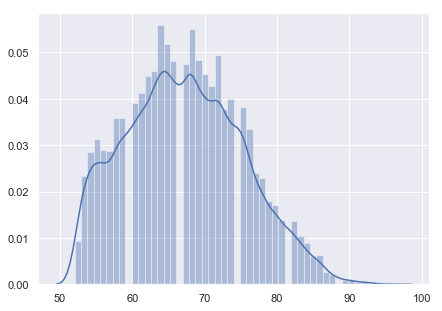

In [251]:
sns.distplot(above)

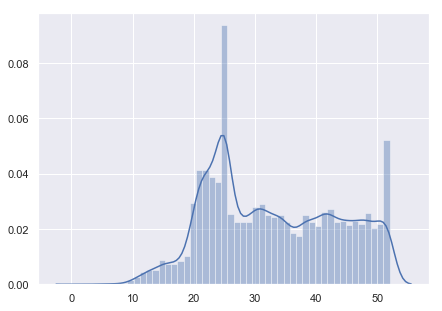

In [252]:
sns.distplot(below)

In [259]:
aggression_binomial = []
for item in df1.aggression:
    if item>=I.mean():
        aggression_binomial.append(1)
    else:
        aggression_binomial.append(0)
        

In [275]:
sum(I_binomial)/len(I_binomial)

0.5578438726369457

In [276]:
stats.binom_test(sum(I_binomial), len(I_binomial), .58, alternative='two-sided')

3.073205353927234e-82

In [272]:
stats.binom_test(sum(interceptions_binomial), len(interceptions_binomial), .2, alternative='two-sided')

1e-323

In [273]:
stats.binom_test(sum(aggression_binomial), len(aggression_binomial), .7, alternative='two-sided')

3.2111783091708e-189

In [261]:
df1.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [262]:
interceptions_binomial = []
for item in df1.interceptions:
    if item>=I.mean():
        interceptions_binomial.append(1)
    else:
        interceptions_binomial.append(0)
        

In [72]:
independent_ttest(H, Aw, alpha)

(41.02469141216727, 51956, 1.6448829555464886, 0.0)

In [255]:
I_binomial

[1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


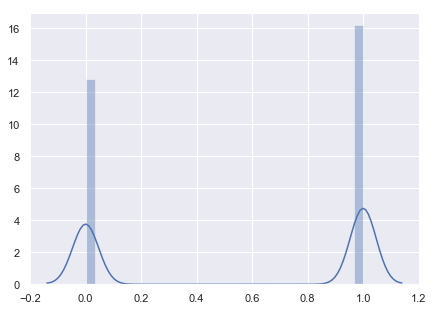

In [257]:
sns.distplot(I_binomial)